In [1]:
import warnings
from utils.plotting_helpers import plot_weights
from environements.portfolio_optimization_env_flat import PortfolioOptimizationEnvFlat
import matplotlib as mpl
from utils.portfolio_trainer import PortfolioOptimization
from pandas import read_csv
from utils.feature_engineer import FeatureEngineer
from utils.helpers import data_split
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scienceplots
from utils.plotting_helpers import plot_mvo_weights
import utils.mean_variance_optimization as mvo
df_dow = read_csv('./data/dow.csv')
from utils.mean_variance_optimization import mvo_data

# mpl.rcParams['figure.dpi'] = 300
import math
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')
warnings.filterwarnings("ignore")


def linear_schedule(initial_value):
    def scheduler(progress_remaining):
        return initial_value * progress_remaining
    return scheduler

In [2]:
df = df_dow.copy()

df = df_dow[df_dow.tic.isin([ 'AXP', 'DIS', 'GS', 'MMM', 'UNH','MCD','CAT','CRM','V','AMGN','TRV','MSFT'])]
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'
INDICATORS = [
    "macd",
    "rsi_30",
]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list=INDICATORS,
                     use_turbulence=False,
                     user_defined_feature=True)

processed_prcies = fe.preprocess_data(df.query('date>"2000-01-01"'))
cleaned_data = processed_prcies.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf, 0)
stock_dimension = len(cleaned_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 10


In [3]:
# Compute exponentially weighted std of log returns
for window in [21, 42, 63]:
    cleaned_data[f'std_return_{window}'] = cleaned_data.groupby('tic')['log_return'] \
        .transform(lambda x: x.ewm(span=window, min_periods=50,adjust=False).std())
# Compute exponentially weighted std of closing prices for MACD normalization
cleaned_data['ewma_std_price_63'] = cleaned_data.groupby('tic')['close'] \
    .transform(lambda x: x.ewm(span=63, min_periods=50,adjust=False).std())

# Normalize MACD by price volatility
cleaned_data['macd_normal'] = cleaned_data['macd'] / cleaned_data['ewma_std_price_63']

# Rolling cumulative log returns over different periods
for window in [5, 21, 42, 63]:
    cleaned_data[f'price_lag_{window}'] = cleaned_data.groupby('tic')['log_return'] \
        .transform(lambda x: x.rolling(window=window, min_periods=1).sum())

# Normalize rolling log returns by their respective volatilities
for window in [21, 42, 63]:
    cleaned_data[f'r_{window}'] = cleaned_data[f'price_lag_{window}'] / cleaned_data[f'std_return_{window}']

# Normalize RSI (if needed)
cleaned_data['rsi'] = cleaned_data['rsi_30'] / 100

In [4]:
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf, 0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(
    cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 10


In [5]:
train_data.isna().sum()

Unnamed: 0           0
date                 0
open                 0
high                 0
low                  0
close                0
volume               0
tic                  0
day                  0
macd                 0
rsi_30               0
return               0
log_return           0
std_return_21        0
std_return_42        0
std_return_63        0
ewma_std_price_63    0
macd_normal          0
price_lag_5          0
price_lag_21         0
price_lag_42         0
price_lag_63         0
r_21                 0
r_42                 0
r_63                 0
rsi                  0
dtype: int64

In [ ]:
pv_simple_return = cleaned_data.pivot_table(index='date',values='return',columns='tic')
pv_simple_log_return = cleaned_data.pivot_table(index='date',values='log_return',columns='tic')
pv_simple_rsi = cleaned_data.pivot_table(index='date',values='rsi',columns='tic')
pv_simple_macd_normal= cleaned_data.pivot_table(index='date',values='macd_normal',columns='tic')
pv_simple_std= cleaned_data.pivot_table(index='date',values='ewma_std_price_63',columns='tic')
pv_m_21= cleaned_data.pivot_table(index='date',values='price_lag_21',columns='tic')



<Axes: xlabel='date'>

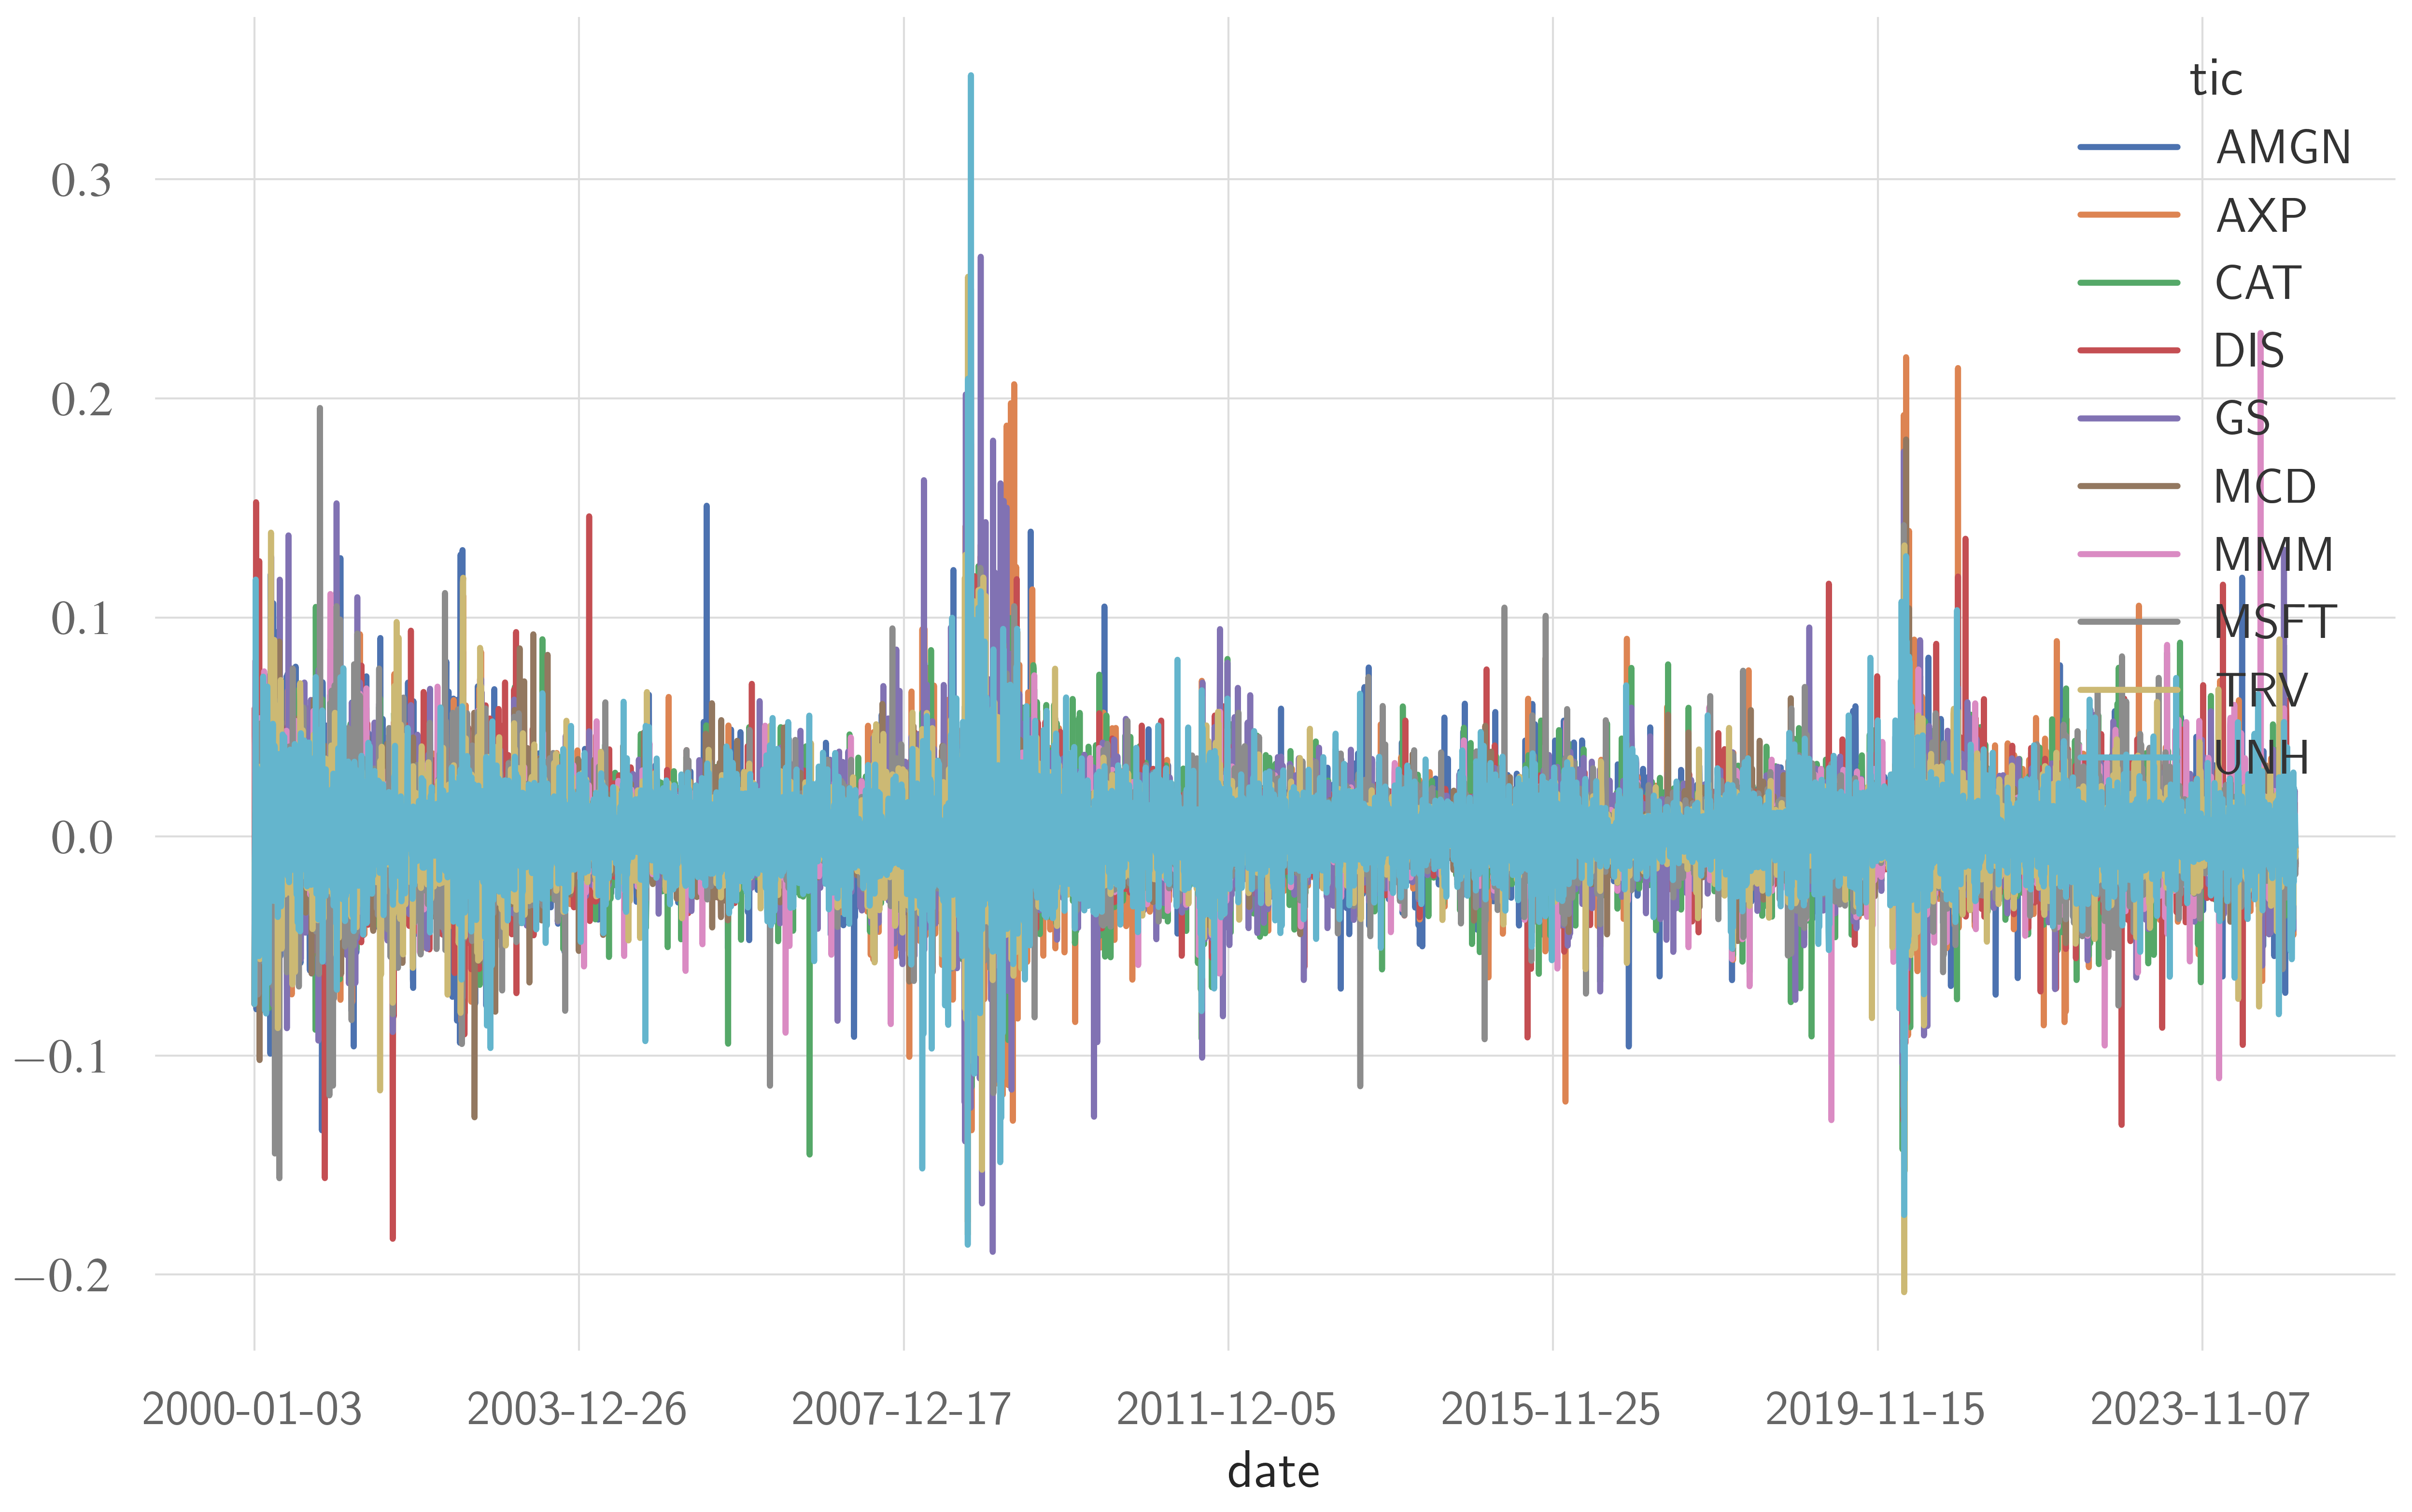

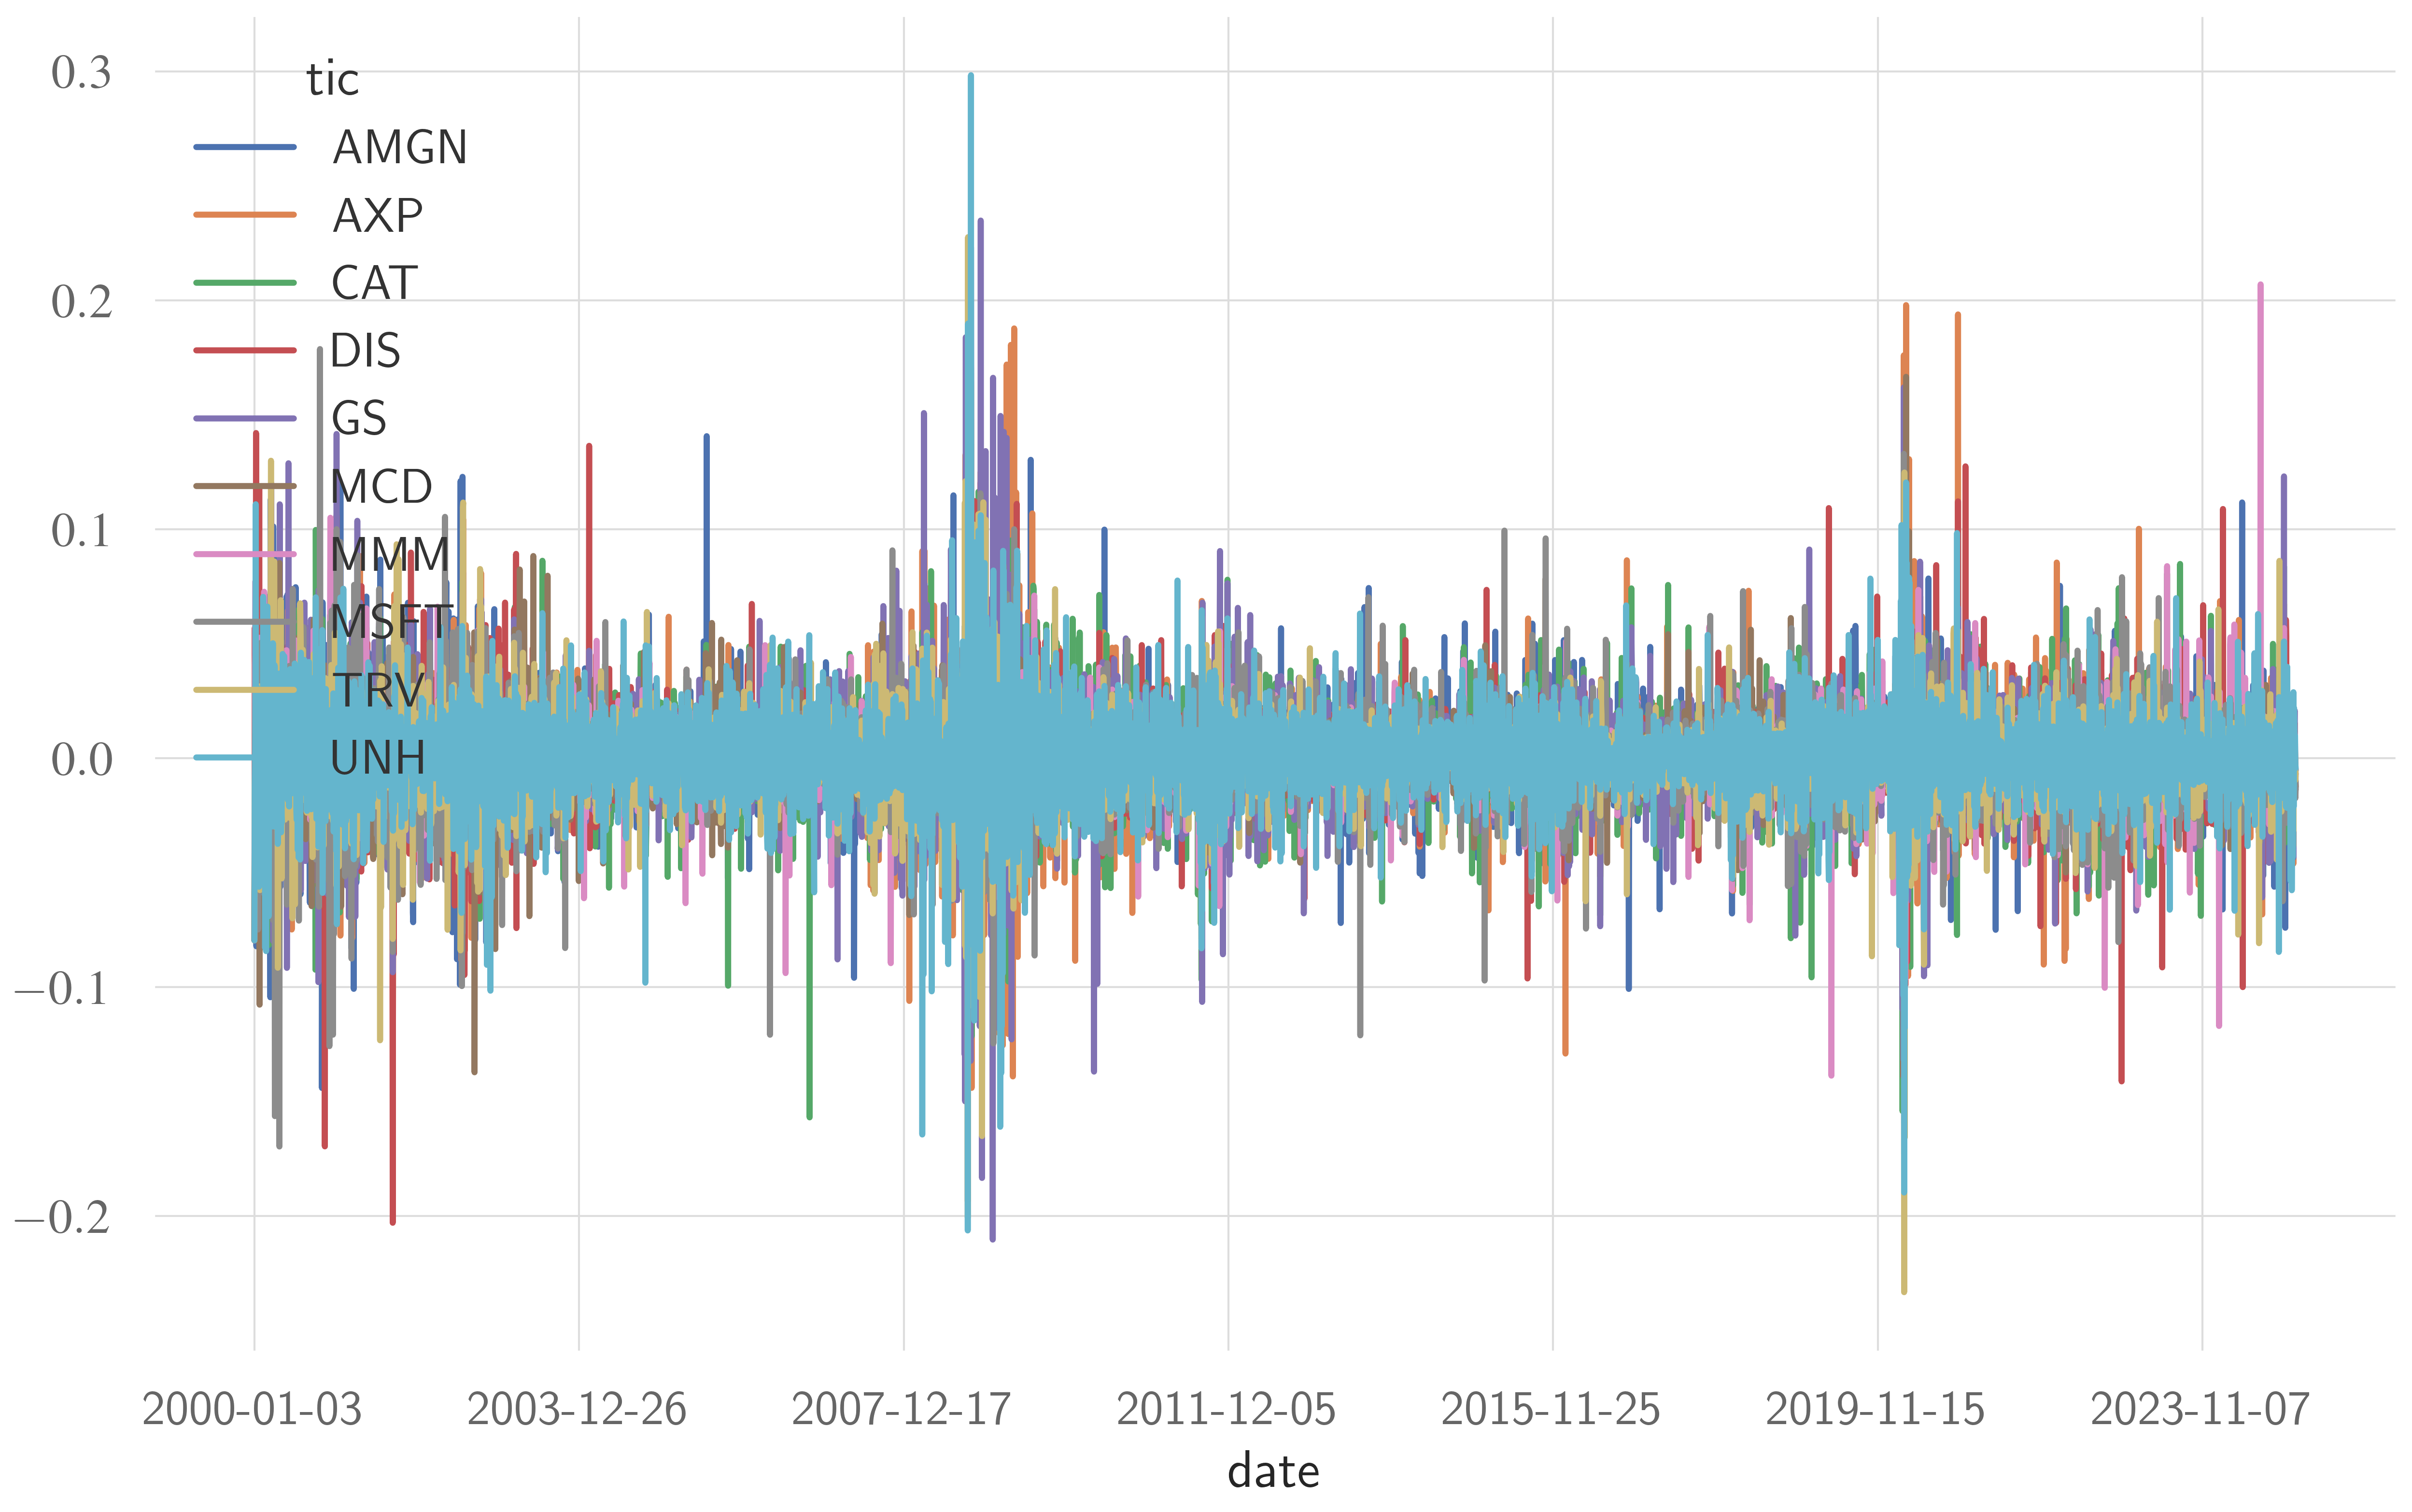

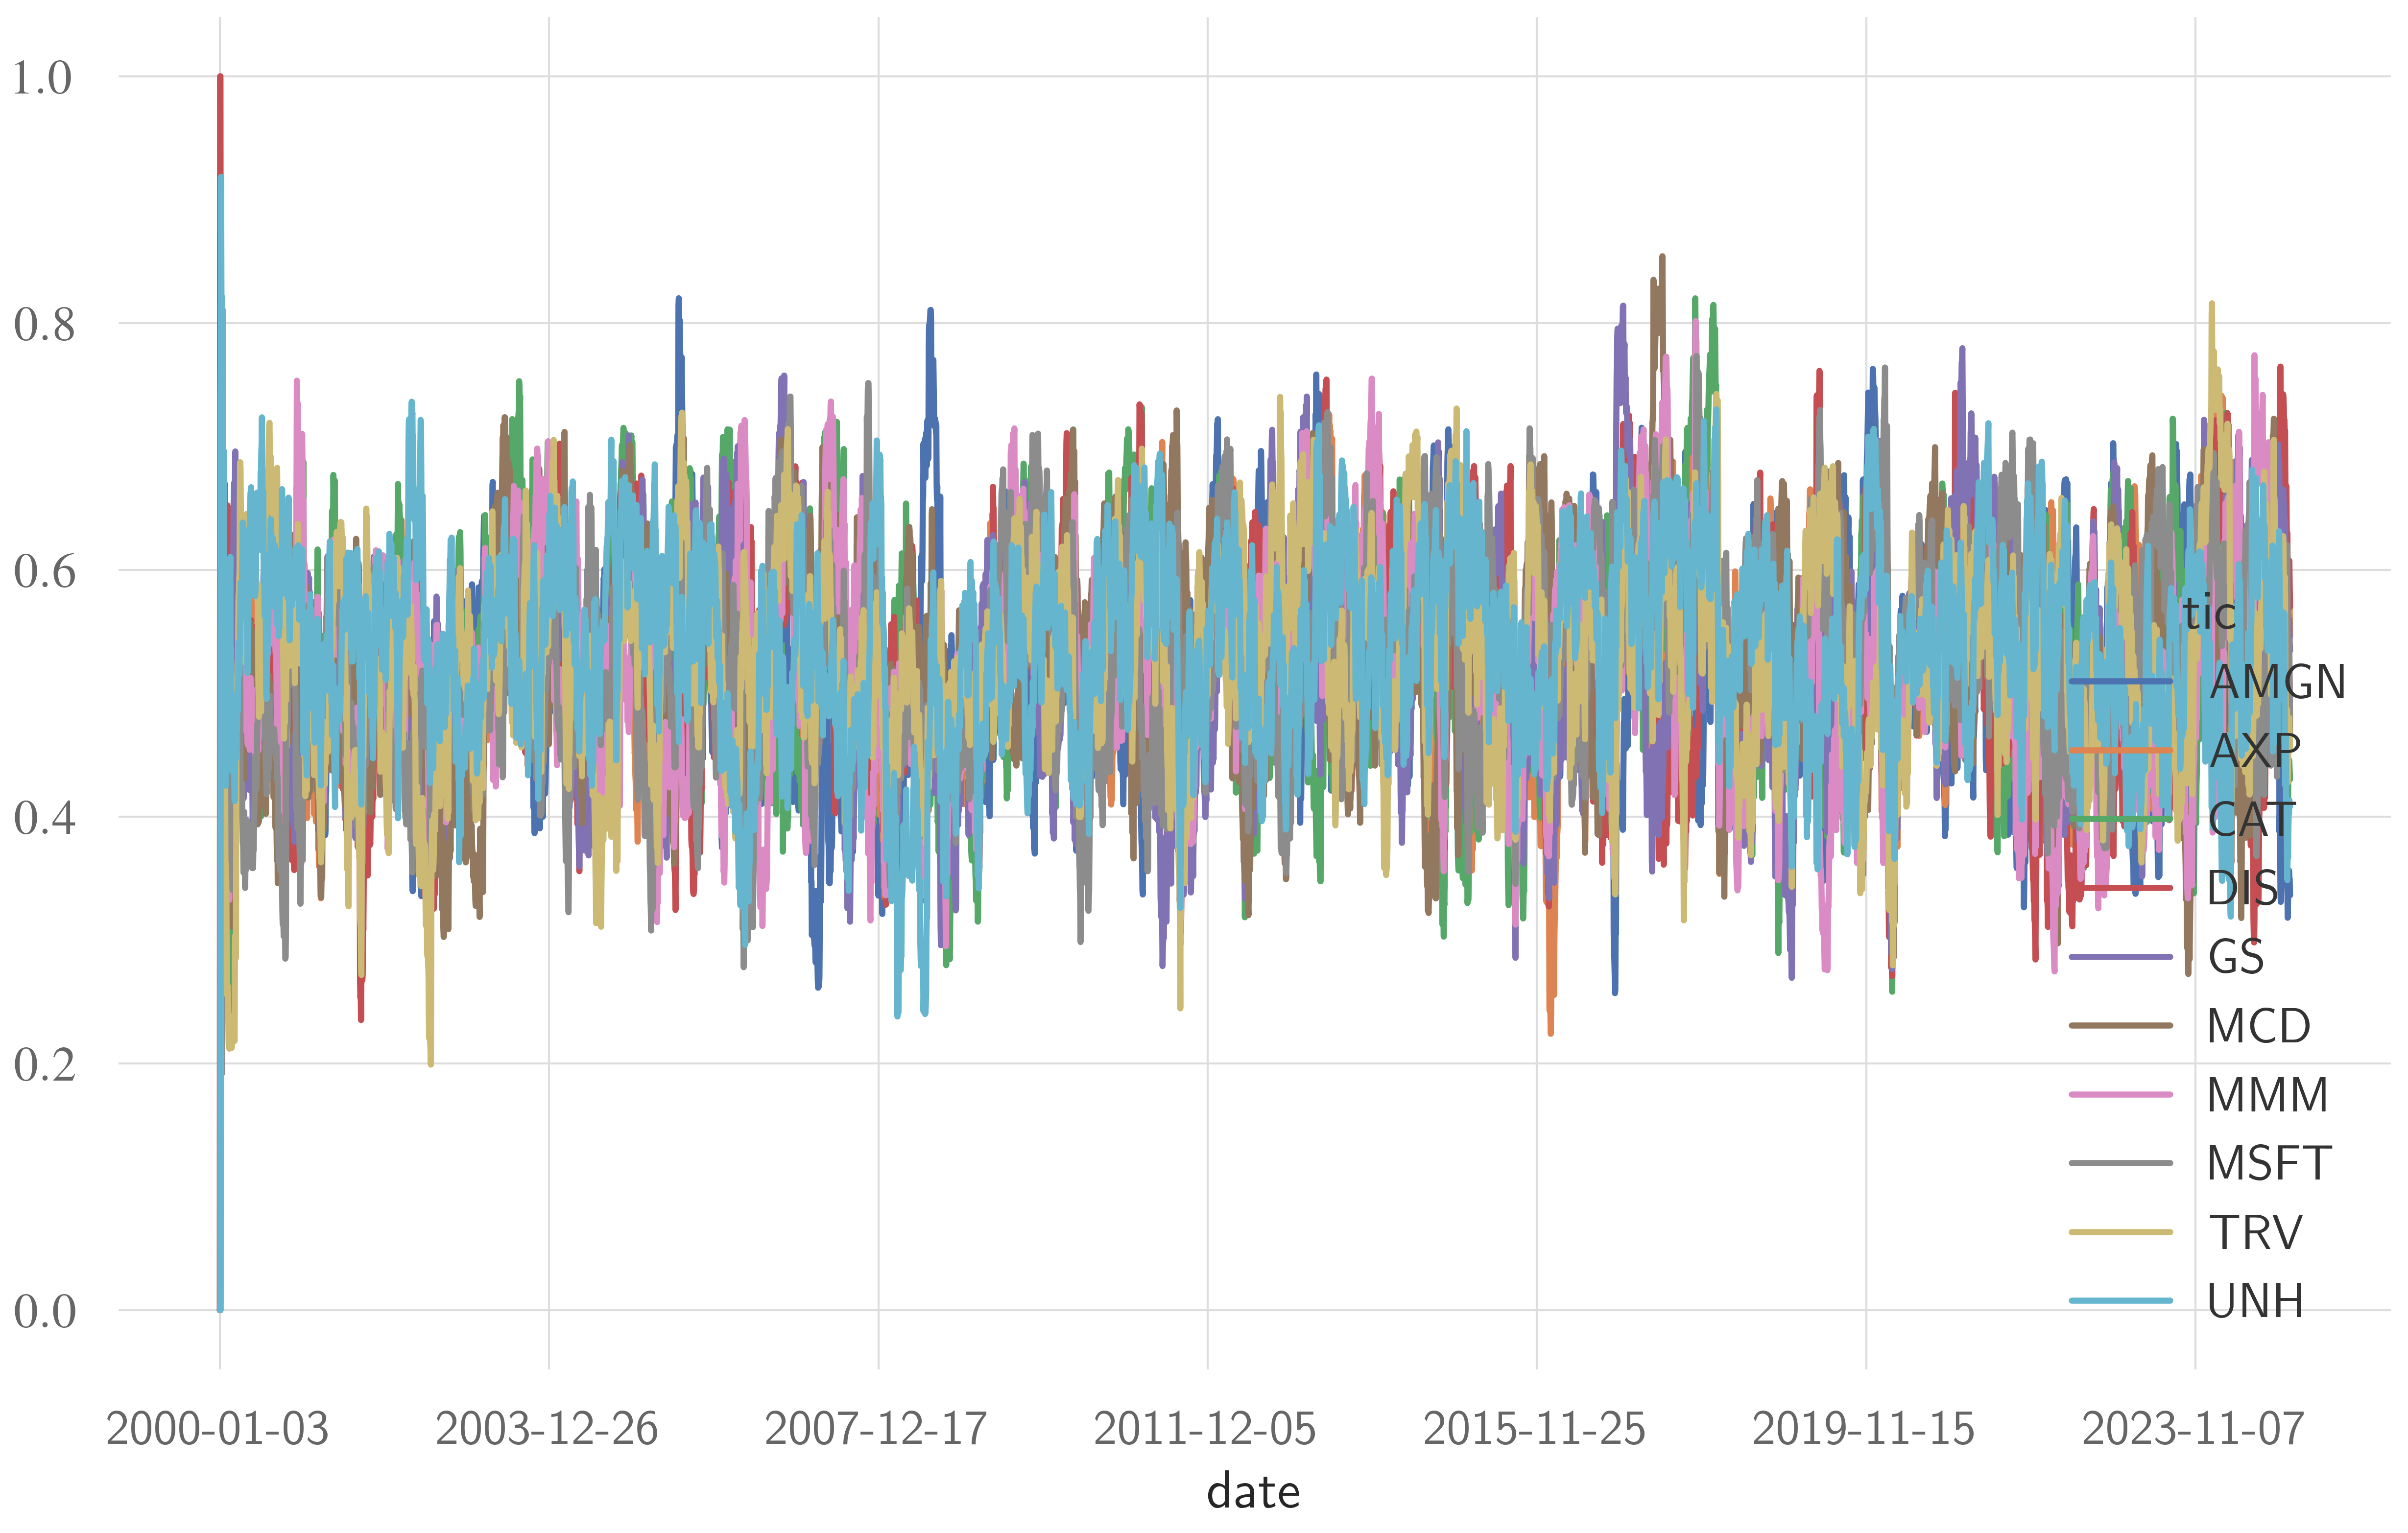

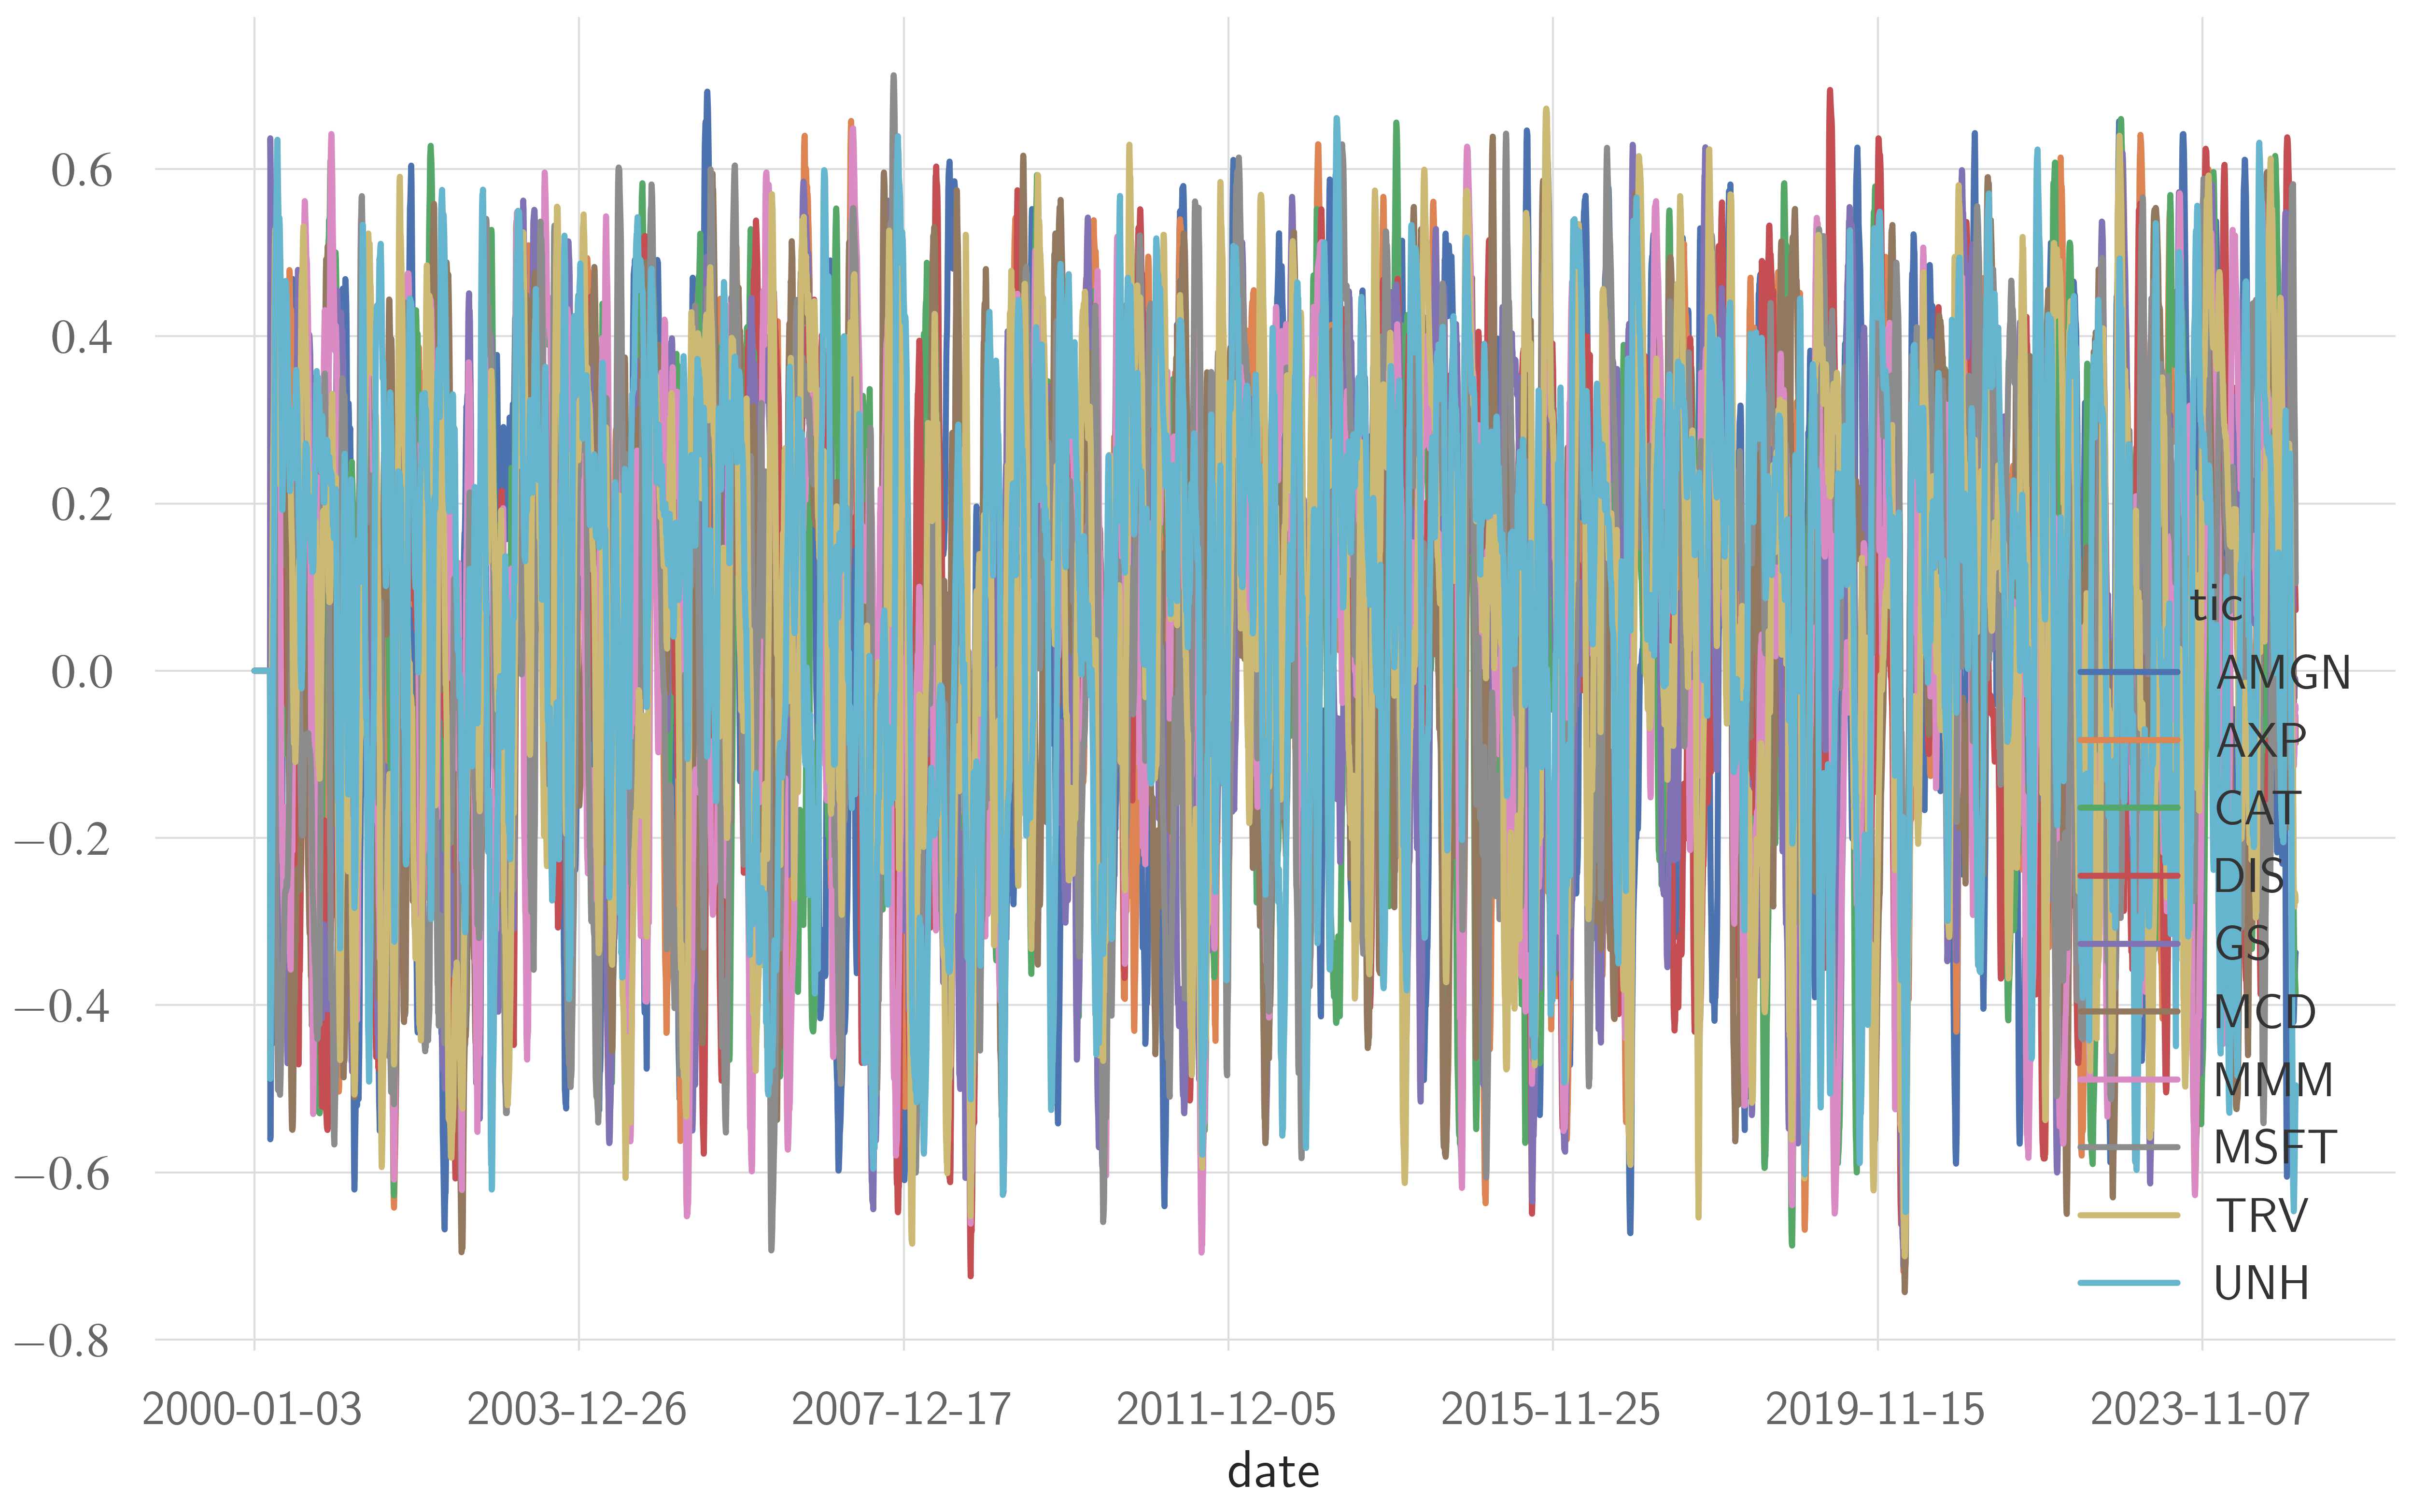

In [ ]:
%matplotlib inline

pv_simple_return.plot()
pv_simple_log_return.plot()
pv_simple_rsi.plot()
pv_simple_macd_normal.plot()



# Proximal Policy Optimization

In [7]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0, comission_fee_model=None, vectorize=False, normalize=None, clip_range=0.04,
    tag="fixed_ppo", sharp_reward=False, last_weight=False, remove_close=True,
    add_cash=False, env=PortfolioOptimizationEnv
)
# optimizer.train_model(train_data,
#                       validation_data,
#                       features=["close", "log_return", "r_21", "r_42", "r_63",
#                                 "macd", "rsi"
#                                 ],
#                       model_name="ppo",
#                       args={"n_steps":  1024, "batch_size": 64, 'learning_rate': 1e-4,
#                             'gamma': 0.85, 'gae_lambda': 0.85, 'ent_coef': 0.05},
#                       window_size=5,
#                       iterations=1000_000)

test_env = optimizer.create_environment(test_data,features=[
                                "close", "log_return", "r_21", "r_42", "r_63",
                                "macd", "rsi"
                                  ],window=5)
ppo_test_result = optimizer.load_from_file(
    'ppo',test_env, 
    cwd="data\ppo_close_log_return_r_21_r_42_r_63_macd_rsi_window_size_5_0.002_fixed_ppo\ppo_1000000_steps"
    ,deterministic=True)

Successfully load model data\ppo_close_log_return_r_21_r_42_r_63_macd_rsi_window_size_5_0.002_fixed_ppo\ppo_1000000_steps
Initial portfolio value:250000
Final portfolio value: 325571.8125
Final accumulative portfolio value: 1.302287220954895
Maximum DrawDown: -0.1786877915559083
Sharpe ratio: 0.6357250530217361


In [24]:
ppo_test_result[0]

date  daily_return        account  \
0   2021-01-08      0.000000  250000.000000   
1   2021-01-11     -0.005821  248544.875000   
2   2021-01-12      0.000237  248603.812500   
3   2021-01-13      0.002196  249149.828125   
4   2021-01-14     -0.001414  248797.625000   
..         ...           ...            ...   
744 2023-12-22      0.001307  334400.312500   
745 2023-12-26      0.005040  336085.812500   
746 2023-12-27      0.004354  337548.968750   
747 2023-12-28      0.003886  338860.656250   
748 2023-12-29      0.000580  339057.156250   

                                               weights  
0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1    [0.13639505, 0.050073445, 0.050267536, 0.13722...  
2    [0.1332579, 0.049453616, 0.050160352, 0.131493...  
3    [0.14253798, 0.052517794, 0.051747262, 0.14195...  
4    [0.14797558, 0.054157943, 0.05396696, 0.143351...  
..                                                 ...  
744  [0.05464692, 0.05394481, 0.05377176, 0.1444339...  
745  [0.05346956, 0.053631008, 0.054489892, 0.14536...  
746  [0.056576565, 0.05372885, 0.05386277, 0.144281...  
747  [0.05394097, 0.053792033, 0.053357217, 0.14567...  
748  [0.053675104, 0.05362543, 0.053538002, 0.14594...  

[749 rows x 4 columns]

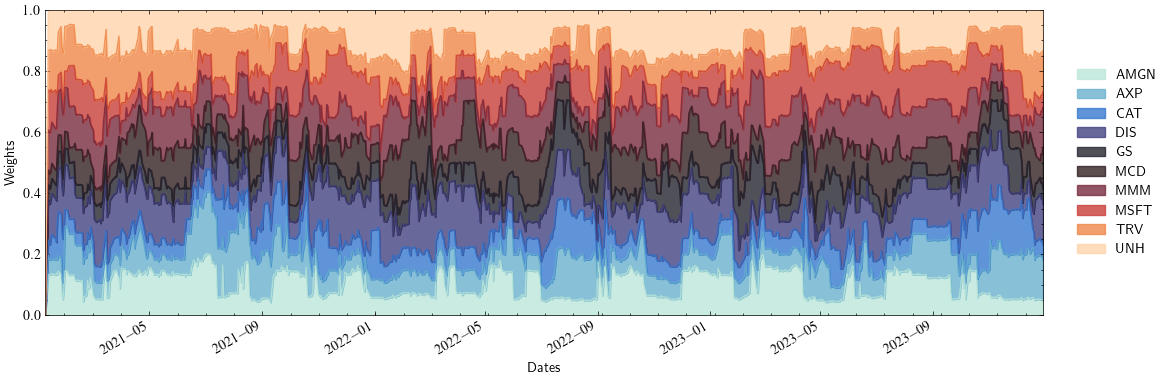

In [8]:
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False)

# Mean Variance Optimization

In [5]:
covariances = mvo_data(cleaned_data,TEST_START_DATE,TEST_END_DATE,returns_model='mean_historical_return',risk_model='sample_cov')

In [48]:
from utils.helpers import data_split
from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent
from pypfopt import EfficientFrontier, expected_returns, risk_models
import pandas as pd
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
import numpy as np
def mean_variance_optimization(test_data, solver='OSQP', window=1, commission_fee=0, objective='min_variance'):
    z = test_data.copy()
    z.sort_values(by=['date','tic'])
    environment = PortfolioOptimizationEnv(
        test_data,
        initial_amount=1000000,
        comission_fee_pct=commission_fee,
        time_window=window,
        features=["close", "return"],
        normalize_df=None,
        add_cash=False,
        use_softmax=False
    )

    variances = []
    environment.reset()
    terminated = False
    environment.reset()
    weights_list=[]
    
    for index in z.index.unique():
        print(z.loc[index].iloc[0].date)
        mean_returns = z.loc[index].iloc[0].returns
        cov = z.loc[index].iloc[0].cov_list
        ef = EfficientFrontier(mean_returns, cov, solver=solver)
        if objective == 'min_variance':
            ef.min_volatility()
            weights = ef.clean_weights()

        else:
            ef.max_sharpe()
            weights = ef.clean_weights()
        weights = list(weights.values())
        weights_list.append(weights)
        w = np.array(weights)
        _, _, terminated, _, _ = environment.step(weights)
        variances.append(np.dot(w.T, np.dot(cov, w)))
        if terminated:
            break
    date_list = environment._date_memory
    portfolio_return = environment._portfolio_return_memory
    result_df = pd.DataFrame(
        {"date": date_list, "daily_return": portfolio_return,
            'account':  environment._asset_memory["final"], 'weights': environment._final_weights}
    )
    return result_df,environment._tic_list.tolist(), variances,pd.DataFrame(weights_list) 

In [49]:
min_variacen_portfolio = mean_variance_optimization(covariances,commission_fee=0,window=5)


2021-01-04
2021-01-05
2021-01-06
2021-01-07
2021-01-08
2021-01-11
2021-01-12
2021-01-13
2021-01-14
2021-01-15
2021-01-19
2021-01-20
2021-01-21
2021-01-22
2021-01-25
2021-01-26
2021-01-27
2021-01-28
2021-01-29
2021-02-01
2021-02-02
2021-02-03
2021-02-04
2021-02-05
2021-02-08
2021-02-09
2021-02-10
2021-02-11
2021-02-12
2021-02-16
2021-02-17
2021-02-18
2021-02-19
2021-02-22
2021-02-23
2021-02-24
2021-02-25
2021-02-26
2021-03-01
2021-03-02
2021-03-03
2021-03-04
2021-03-05
2021-03-08
2021-03-09
2021-03-10
2021-03-11
2021-03-12
2021-03-15
2021-03-16
2021-03-17
2021-03-18
2021-03-19
2021-03-22
2021-03-23
2021-03-24
2021-03-25
2021-03-26
2021-03-29
2021-03-30
2021-03-31
2021-04-01
2021-04-05
2021-04-06
2021-04-07
2021-04-08
2021-04-09
2021-04-12
2021-04-13
2021-04-14
2021-04-15
2021-04-16
2021-04-19
2021-04-20
2021-04-21
2021-04-22
2021-04-23
2021-04-26
2021-04-27
2021-04-28
2021-04-29
2021-04-30
2021-05-03
2021-05-04
2021-05-05
2021-05-06
2021-05-07
2021-05-10
2021-05-11
2021-05-12
2021-05-13

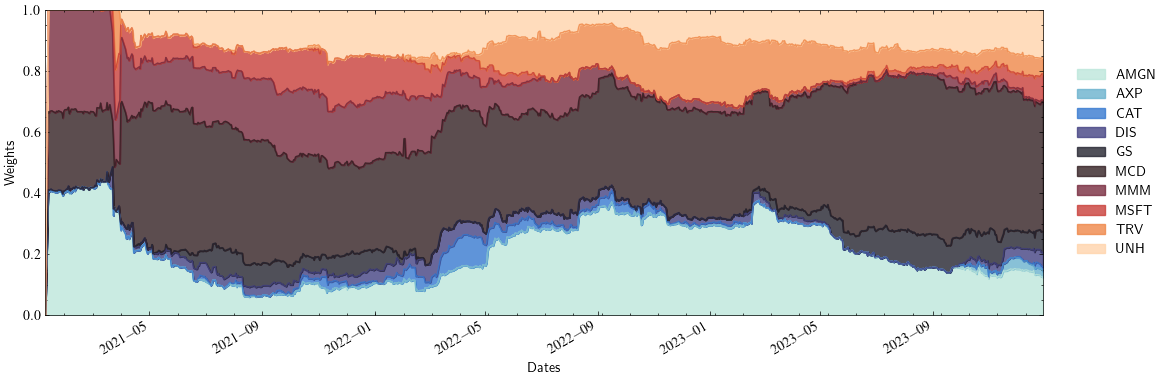

In [50]:
%matplotlib inline
plot_weights(min_variacen_portfolio[0].weights, min_variacen_portfolio[0].date, min_variacen_portfolio[1],add_cash=False)

begin_total_asset:50000
end_total_asset:65829.34679393651
Sharpe:  0.7260201266740914
Test Finished!
episode_return 1.31658693587873


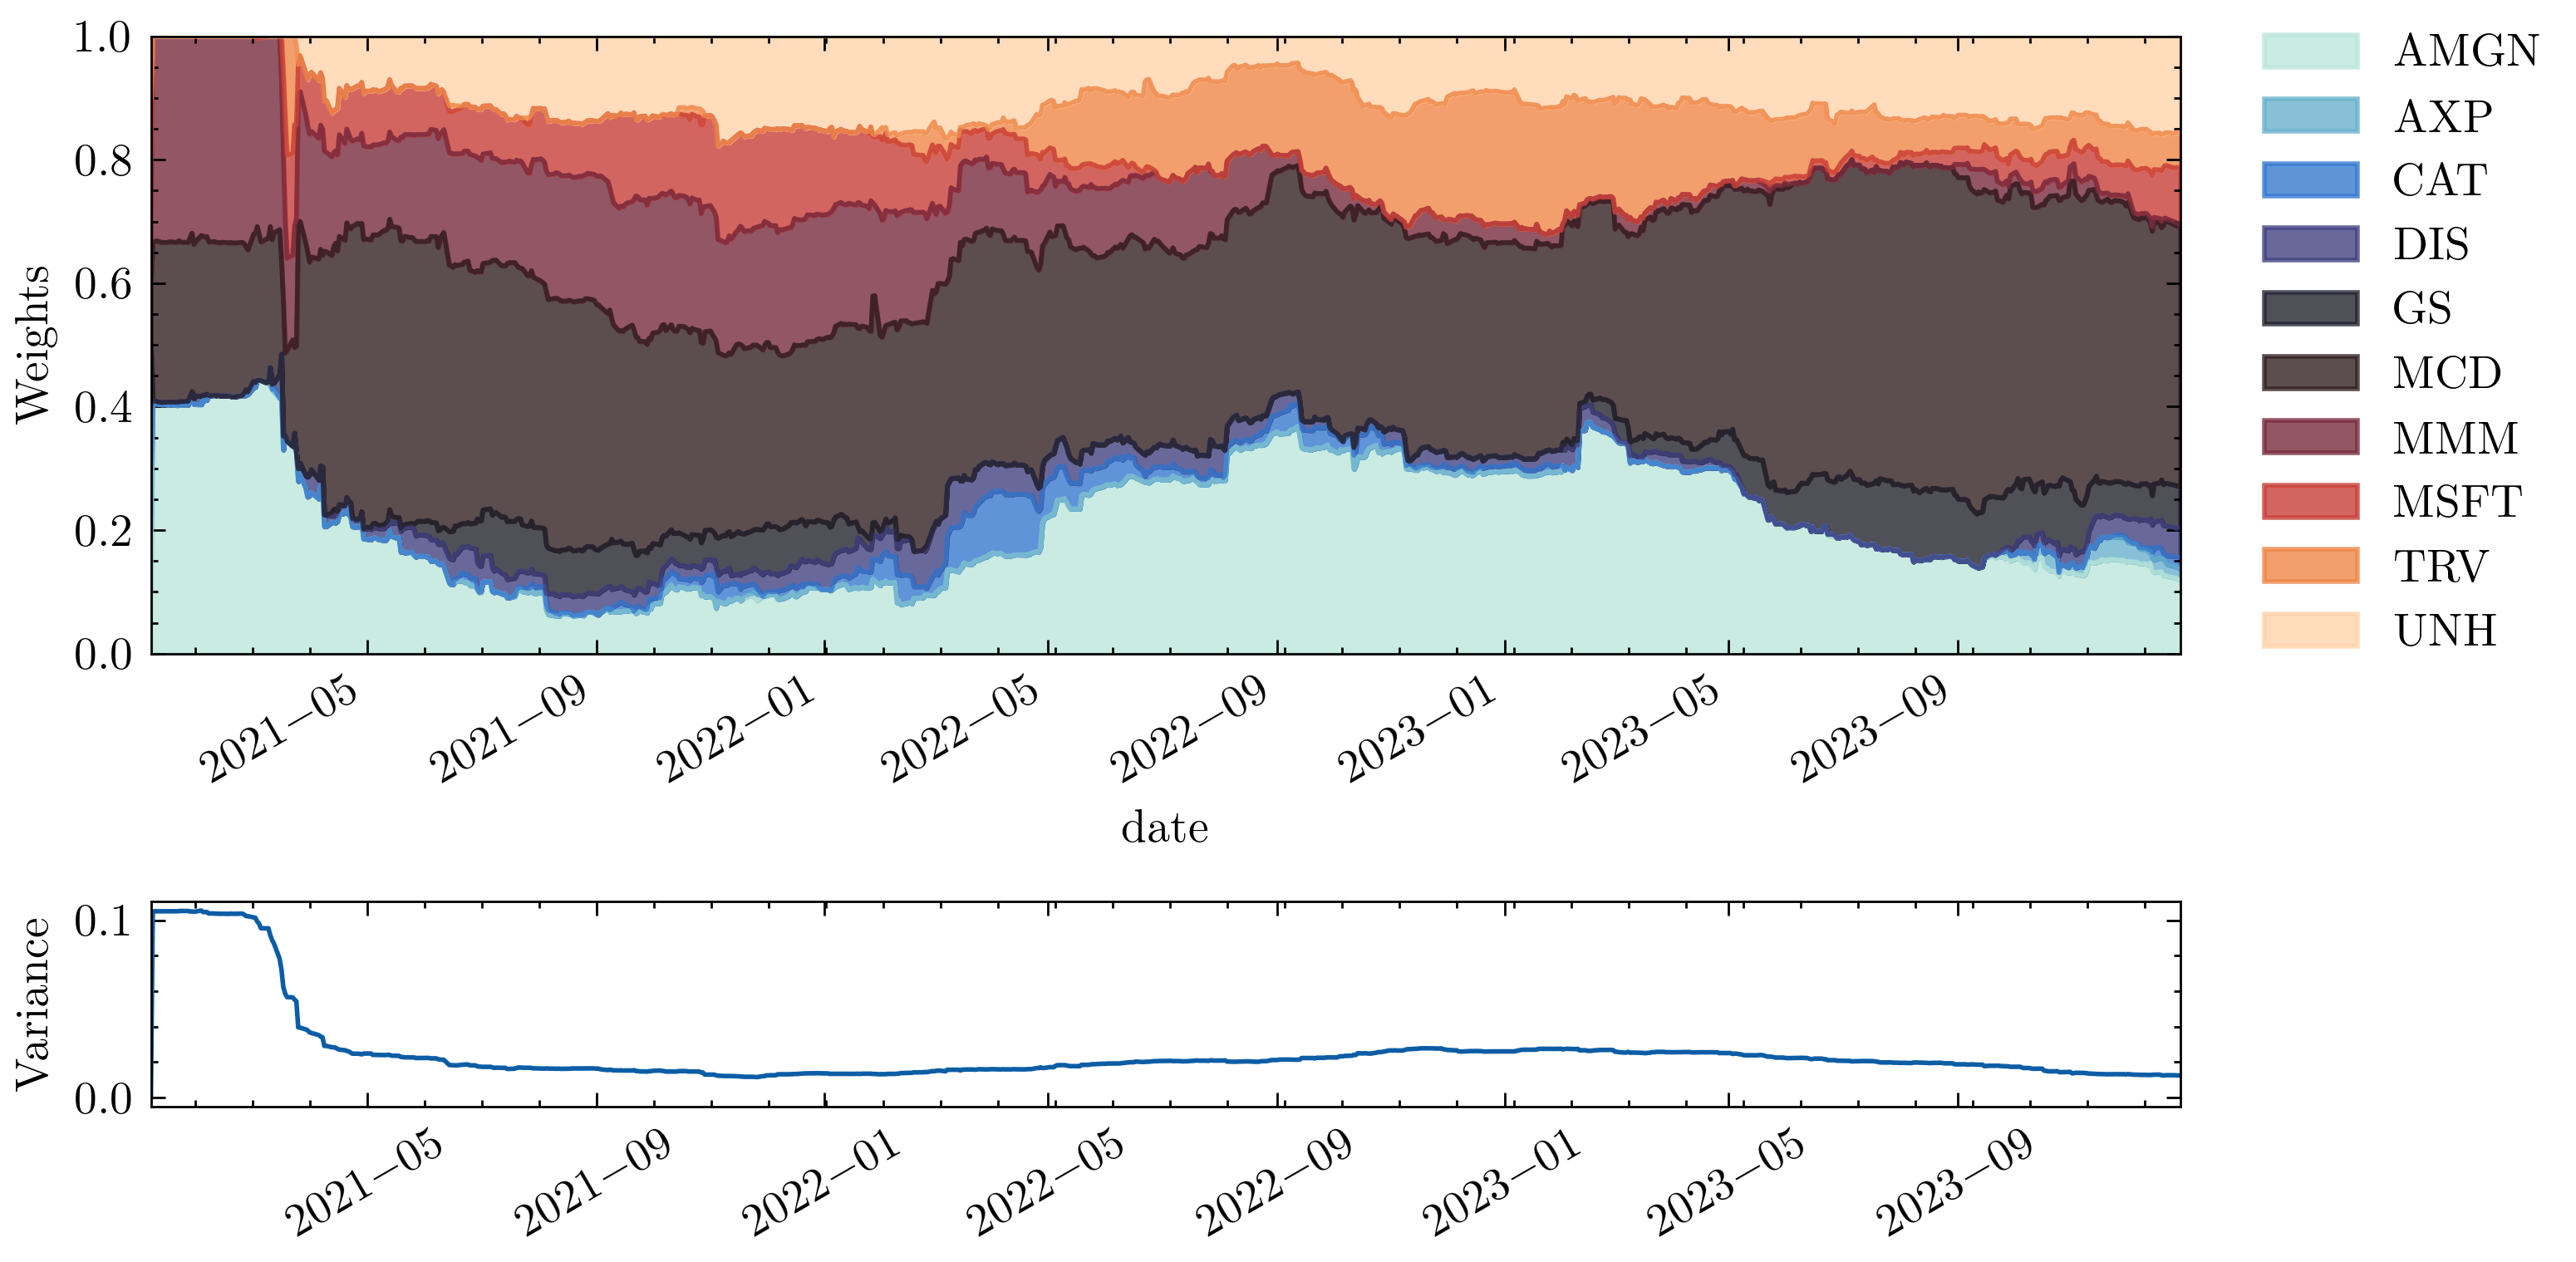

In [6]:
result_sharpe = mvo.mean_variance_optimization(covariances,pct=0)
%matplotlib inline
plot_mvo_weights(result_sharpe,test_data,dpi=400,figsize=(8,4),save_path = 'mvo_sample_cov_mean_sharpe.png')

PPO WITHOUT WEIGHT

Use normalization

In [ ]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0.00, comission_fee_model=None, vectorize=False, normalize=None,
    tag="ppo_alternative_state_11_asset", sharp_reward=False, last_weight=False, remove_close=True,
    add_cash=False, env=PortfolioOptimizationEnv
    )
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","momentum_return_21_normal"
#                                   ,"momentum_return_42_normal","momentum_return_63_normal",
#                                   "macd_normal","rsi_normal"
#                                   ],
#                         model_name="ppo",
#                         args={"n_steps":  256, "batch_size": 64,'learning_rate':1e-4,'gamma':0.90 ,'gae_lambda': 0.85, 'ent_coef': 0.05},
#                         window_size=60,
#                         iterations=400_000)
test_env = optimizer.create_environment(test_data,features=["close", "log_return", "r_21_normal",
                                "r_42_normal", "r_63_normal", "r_252_normal", "macd_normal", "rsi_normal"
                                  ],window=60)
ppo_test_result = optimizer.load_from_file(
    'ppo',test_env, 
    cwd="data\ppo_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_portfolio_return_ppo\ppo_260000_steps"
    ,deterministic=True)


Successfully load model data\ppo_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_portfolio_return_ppo\ppo_260000_steps
Initial portfolio value:250000
Final portfolio value: 262199.625
Final accumulative portfolio value: 1.0487984418869019
Maximum DrawDown: -0.2204810883074637
Sharpe ratio: 0.23582026443643747


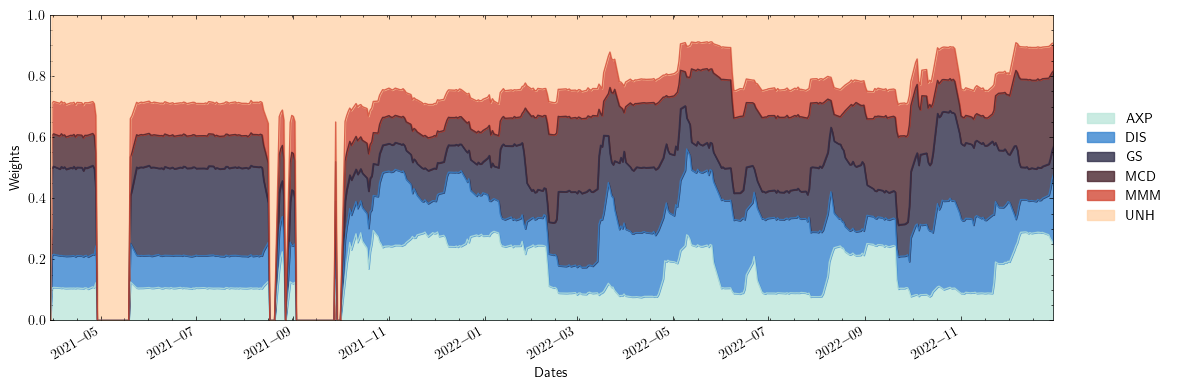

In [ ]:
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False)

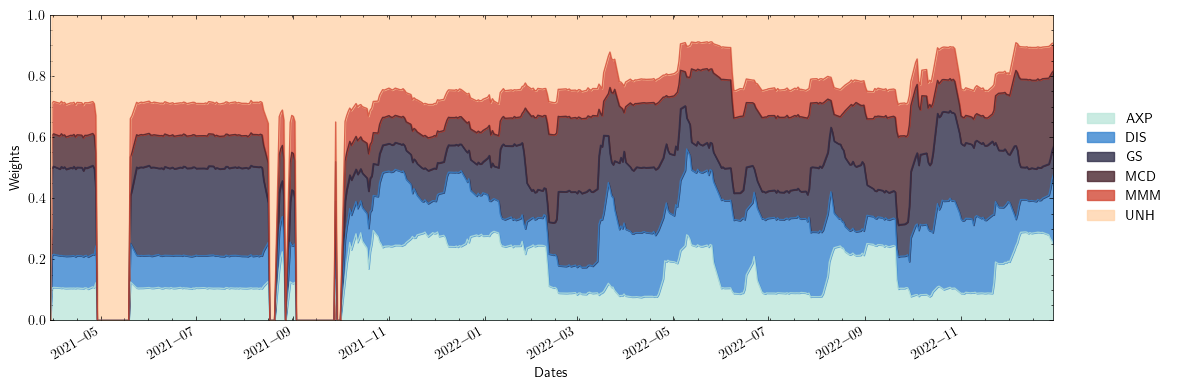

In [ ]:
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False)

In [ ]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0.00, comission_fee_model=None, vectorize=False, normalize=None,
    tag="ppo_alternative_state_11_asset", sharp_reward=False, last_weight=False, remove_close=True,
    add_cash=False, env=PortfolioOptimizationEnv
    )
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","momentum_return_21_normal"
#                                   ,"momentum_return_42_normal","momentum_return_63_normal",
#                                   "macd_normal","rsi_normal"
#                                   ],
#                         model_name="ppo",
#                         args={"n_steps":  256, "batch_size": 64,'learning_rate':1e-4,'gamma':0.90 ,'gae_lambda': 0.85, 'ent_coef': 0.05},
#                         window_size=60,
#                         iterations=400_000)
test_env = optimizer.create_environment(test_data,features=["close", "log_return", "r_21_normal",
                                "r_42_normal", "r_63_normal", "r_252_normal", "macd_normal", "rsi_normal"
                                  ],window=60)
a2c_test_result = optimizer.load_from_file(
    'a2c',test_env, 
    cwd="data/a2c_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_a2c_ret/a2c_130000_steps"
    ,deterministic=True)


Successfully load model data/a2c_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_a2c_ret/a2c_130000_steps
Initial portfolio value:250000
Final portfolio value: 192655.375
Final accumulative portfolio value: 0.7706214785575867
Maximum DrawDown: -0.34089284004725384
Sharpe ratio: -0.5424350110453228


# Buy and Hold

In [5]:
from environements.portfolio_optimization_env import PortfolioOptimizationEnv


stock_dimension = len(test_data.tic.unique())
environment_train_buy_and_hold_sp500 = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0,
    time_window=5,
    features = ["close","return"],
    normalize_df=None,
    add_cash=False
)
terminated = False

environment_train_buy_and_hold_sp500.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated,_, _ = environment_train_buy_and_hold_sp500.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1339321.375
Final accumulative portfolio value: 1.3393213748931885
Maximum DrawDown: -0.18659573293420295
Sharpe ratio: 0.6890450873214902


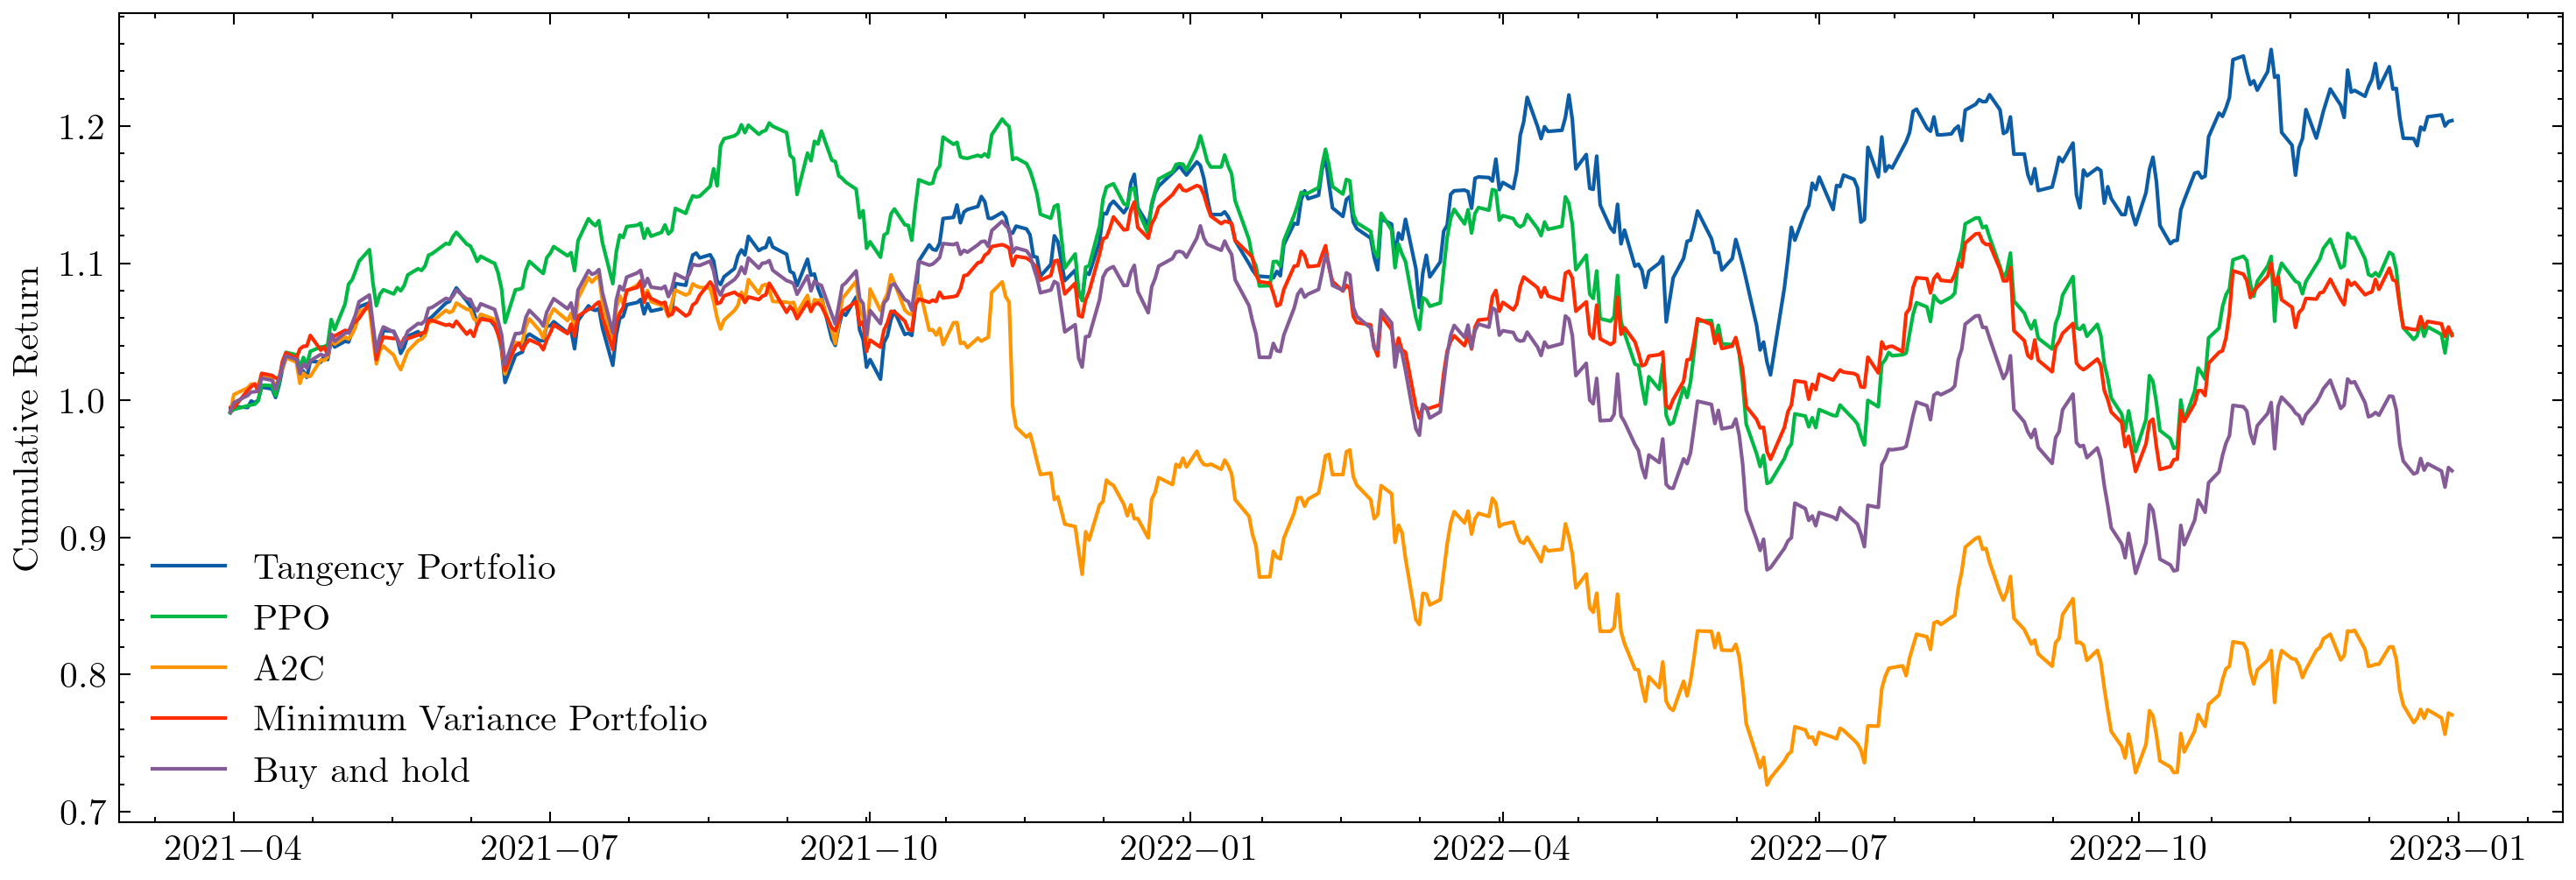

In [ ]:
import matplotlib.pyplot as plt
import scienceplots
plt.rcdefaults()
%matplotlib inline
with plt.style.context('science', 'ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(result_sharpe['test'].date,(result_sharpe['test'].total_assets.pct_change() + 1).cumprod(),label='Tangency Portfolio')
    plt.plot(ppo_test_result[0].get('date'),(ppo_test_result[0]['account'].pct_change() +1).cumprod(),label='PPO')
    plt.plot(a2c_test_result[0].get('date'),(a2c_test_result[0]['account'].pct_change() +1).cumprod(),label='A2C')
    plt.plot(min_variacen_portfolio['test'].date,(min_variacen_portfolio['test'].total_assets.pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
    plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.savefig('dow_comparison.png', dpi=500)
    plt.show()

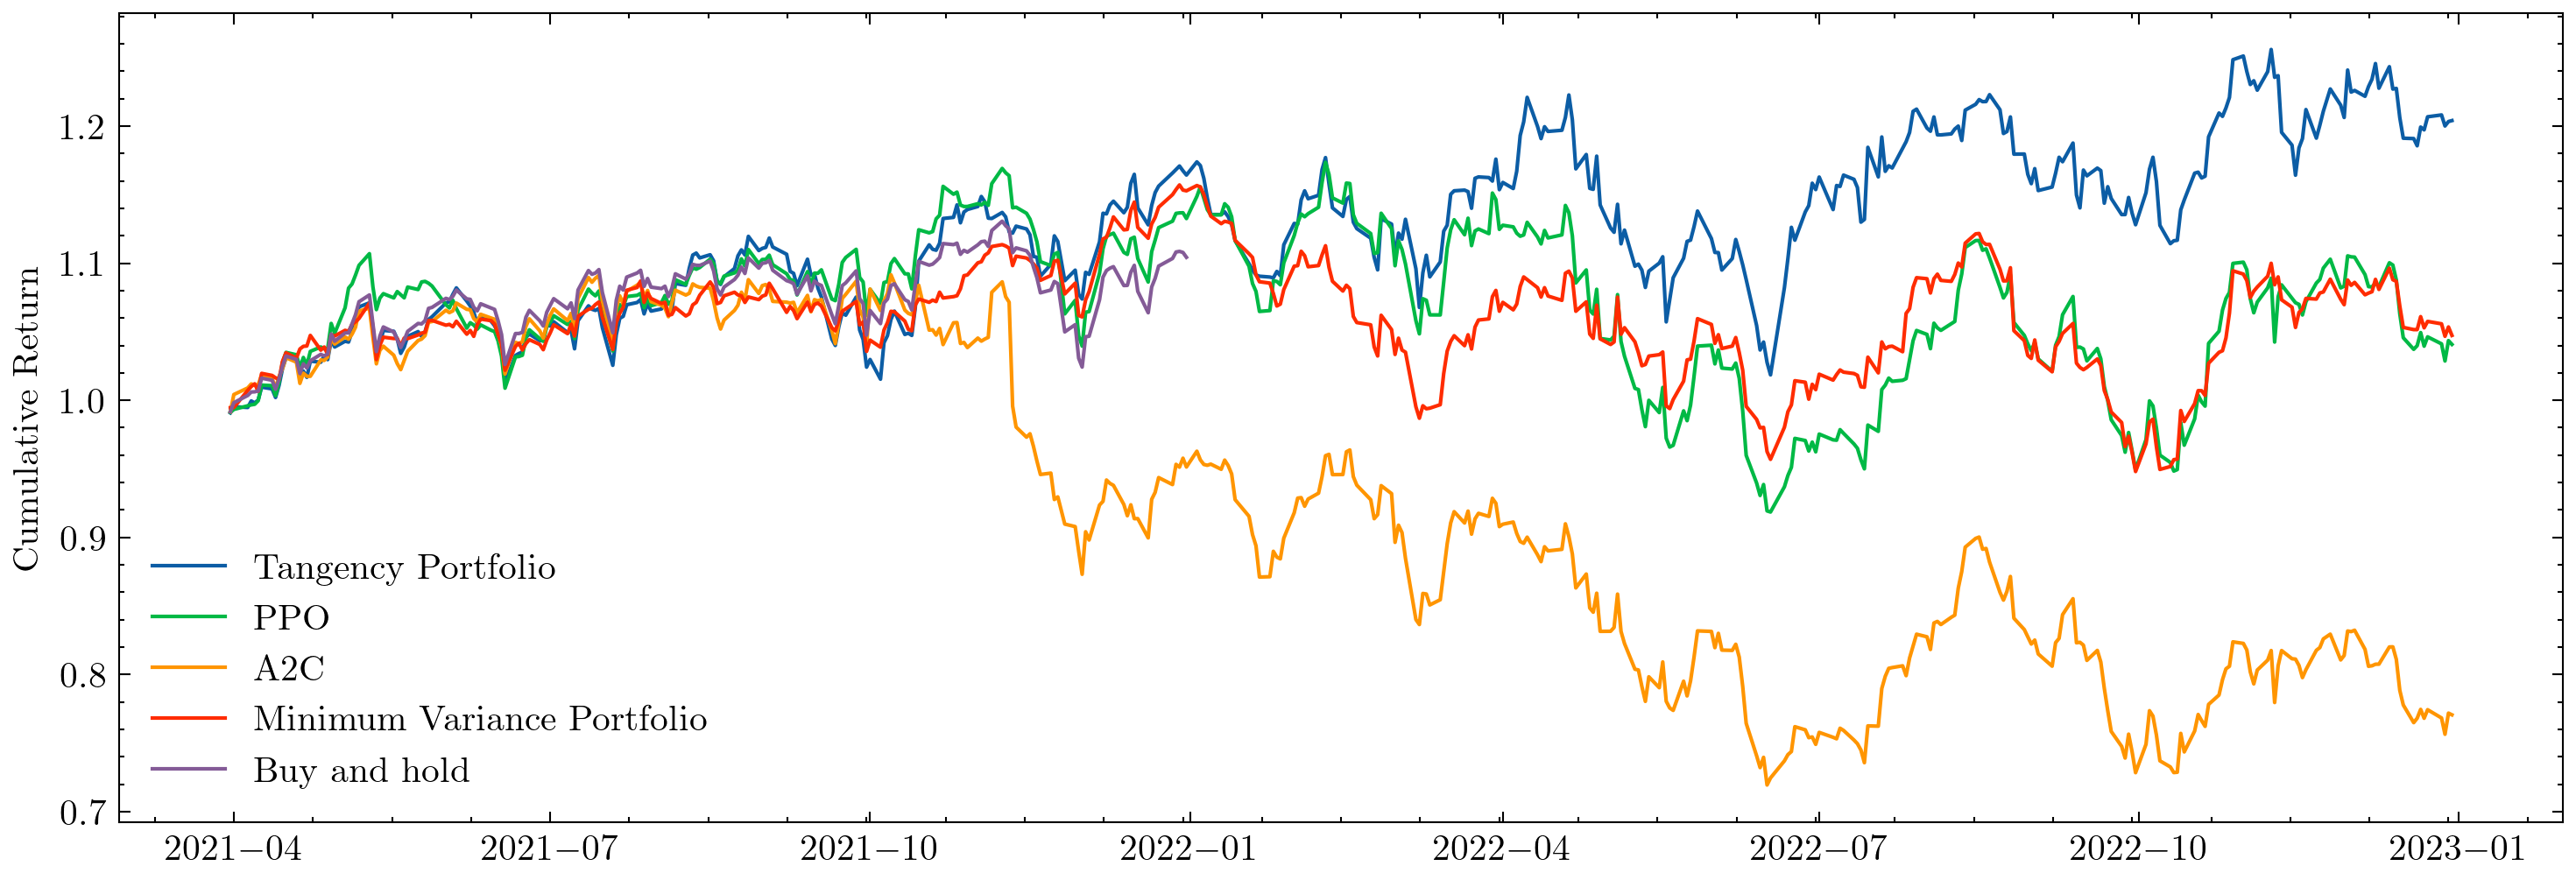

In [ ]:
import matplotlib.pyplot as plt
import scienceplots
plt.rcdefaults()
%matplotlib inline
with plt.style.context('science', 'ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(result_sharpe['test'].date,(result_sharpe['test'].total_assets.pct_change() + 1).cumprod(),label='Tangency Portfolio')
    plt.plot(ppo_test_result[0].get('date'),(ppo_test_result[0]['account'].pct_change() +1).cumprod(),label='PPO')
    plt.plot(a2c_test_result[0].get('date'),(a2c_test_result[0]['account'].pct_change() +1).cumprod(),label='A2C')
    plt.plot(min_variacen_portfolio['test'].date,(min_variacen_portfolio['test'].total_assets.pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
    plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.savefig('dow_comparison.png', dpi=500)
    plt.show()

In [ ]:
import quantstats as qs

In [ ]:
ppo_returns = ppo_test_result[0][['date','account']]

ppo_stats={}
ppo_returns.set_index('date',inplace=True)
ppo_stats['name']  = 'Proximal Policy Optimization'
ppo_stats['sharpe_ratio'] = qs.stats.sharpe(ppo_returns)['account']
ppo_stats['max_drow_down'] = qs.stats.max_drawdown(ppo_returns)['account']
ppo_stats['var'] = qs.stats.var(ppo_returns)[0].item()
ppo_stats['return'] = qs.stats.comp(ppo_returns['account'].pct_change())
ppo_stats

{'name': 'Proximal Policy Optimization',
 'sharpe_ratio': np.float64(0.3388092143131057),
 'max_drow_down': np.float64(-0.2664428956423516),
 'var': -0.02301269977821848,
 'return': np.float64(0.09390949999999965)}

In [ ]:
mvo_min_returns = min_variacen_portfolio['test'][['date','total_assets']]
mvo_min_returns.set_index('date',inplace=True)

mvo_min_stats={}
mvo_min_stats['name']  = 'Min variance portfolio'
mvo_min_stats['sharpe_ratio'] = qs.stats.sharpe(mvo_min_returns)['total_assets']
mvo_min_stats['max_drow_down']  = qs.stats.max_drawdown(mvo_min_returns)['total_assets']
mvo_min_stats['var']  = qs.stats.var(mvo_min_returns)[0].item()
mvo_min_stats['return'] = qs.stats.comp(mvo_min_returns['total_assets'].pct_change())
mvo_min_stats

{'name': 'Min variance portfolio',
 'sharpe_ratio': np.float64(0.2633164866290335),
 'max_drow_down': np.float64(-0.18063587669076375),
 'var': -0.01639642306661718,
 'return': np.float64(0.05302095955995423)}

In [ ]:

mvo_sharpe_returns = result_sharpe['test'][['date','total_assets']]
mvo_sharpe_returns.set_index('date',inplace=True)
mvo_sharpe_stats={}
mvo_sharpe_stats['name']  = 'Tangency Portfolio'
mvo_sharpe_stats['sharpe_ratio'] = qs.stats.sharpe(mvo_sharpe_returns)['total_assets']
mvo_sharpe_stats['max_drow_down']  = qs.stats.max_drawdown(mvo_sharpe_returns)['total_assets']
mvo_sharpe_stats['var']  = qs.stats.var(mvo_sharpe_returns)[0].item()
mvo_sharpe_stats['return'] = qs.stats.comp(mvo_sharpe_returns['total_assets'].pct_change())
mvo_sharpe_stats

{'name': 'Tangency Portfolio',
 'sharpe_ratio': np.float64(0.666227580986604),
 'max_drow_down': np.float64(-0.16693110888675866),
 'var': -0.019609587852893476,
 'return': np.float64(0.21507314715763637)}

In [ ]:
bh_df = pd.DataFrame()
bh_df['asset']=environment_train_buy_and_hold_sp500._portfolio_return_memory
bh_df['date']=environment_train_buy_and_hold_sp500._date_memory
bh_df.set_index('date',inplace=True)
bh_stats={}
bh_stats['name']  = 'Buy and Hold'
bh_stats['sharpe_ratio'] = qs.stats.sharpe(bh_df)['asset']
bh_stats['max_drow_down'] = qs.stats.max_drawdown(bh_df)['asset']
bh_stats['var'] = qs.stats.var(bh_df)[0].item()
bh_stats['return'] = qs.stats.comp(bh_df['asset'])

bh_stats

{'name': 'Buy and Hold',
 'sharpe_ratio': np.float64(-0.06122215468658751),
 'max_drow_down': np.float64(-0.22713166127519646),
 'var': -0.019835048058484694,
 'return': np.float64(-0.051356343491552825)}

In [ ]:
stats = [bh_stats,mvo_sharpe_stats,mvo_min_stats,ppo_stats]

In [ ]:
stats_df = pd.DataFrame(stats)

In [ ]:
stats_df

name  sharpe_ratio  max_drow_down       var  \
0                  Buy and Hold     -0.061222      -0.227132 -0.019835   
1            Tangency Portfolio      0.666228      -0.166931 -0.019610   
2        Min variance portfolio      0.263316      -0.180636 -0.016396   
3  Proximal Policy Optimization      0.338809      -0.266443 -0.023013   

     return  
0 -0.051356  
1  0.215073  
2  0.053021  
3  0.093909

In [ ]:
with open('mytable.tex', 'w') as tf:
     tf.write(stats_df.to_latex())